# exp070
バミューダ切り出しで検証　exp045ベース

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [12]:
target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [13]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [14]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [15]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [16]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [17]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [30]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [19]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [20]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [21]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [22]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# 現在のベストスコア確認

In [75]:
df = pd.read_csv('../output/exp056/train.csv')
df = df[df['collectionName'].isin(target)]
res = train_result(df)
print(res.score)
display(res.err)

9.836789162255748


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.581442     16.134227     10.357834
2021-04-22-US-SJC-1_SamsungS20Ultra      4.214457     15.916886     10.065672
2021-04-28-US-SJC-1_Pixel4               3.159024     16.320795      9.739909
2021-04-28-US-SJC-1_SamsungS20Ultra      3.257959     16.580978      9.919468
2021-04-29-US-SJC-2_Pixel4               2.787590     16.190887      9.489239
2021-04-29-US-SJC-2_SamsungS20Ultra      2.754437     16.142788      9.448613

# 相対移動距離をもとにした外れ値除去

In [43]:
train, test, sub, gt = get_data()
train = train[train['collectionName'].isin(target)]

In [45]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [46]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train.to_csv(OUTPUT + '/train_ro.csv', index=False)

# ground_truthを基準にした外れ値除去

In [48]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [49]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if collection in ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']:
            th = 3
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [50]:
def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

In [51]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df = interpolate_remove_point(rog_df)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]
train.to_csv(OUTPUT + '/train_ro_rog.csv', index=False)

In [41]:
res = train_result(train)
print(res.score)
display(res.err)

12.435482208918117


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.411055     21.239017     13.325036
2021-04-22-US-SJC-1_SamsungS20Ultra      5.175638     20.408002     12.791820
2021-04-28-US-SJC-1_Pixel4               3.337257     17.982381     10.659819
2021-04-28-US-SJC-1_SamsungS20Ultra           NaN           NaN           NaN
2021-04-29-US-SJC-2_Pixel4               3.305664     21.780840     12.543252
2021-04-29-US-SJC-2_SamsungS20Ultra      3.617604     22.097364     12.857484

# kalmanフィルタ

In [55]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [56]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_kf.csv', index=False)

In [57]:
res = train_result(train)
print(res.score)
display(res.err)

11.186257093044448


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.196441     19.482418     12.339430
2021-04-22-US-SJC-1_SamsungS20Ultra      4.806975     19.122911     11.964943
2021-04-28-US-SJC-1_Pixel4               2.912916     16.347074      9.629995
2021-04-28-US-SJC-1_SamsungS20Ultra      3.419396     16.608569     10.013983
2021-04-29-US-SJC-2_Pixel4               2.870528     20.057912     11.464220
2021-04-29-US-SJC-2_SamsungS20Ultra      3.099694     20.310251     11.704972

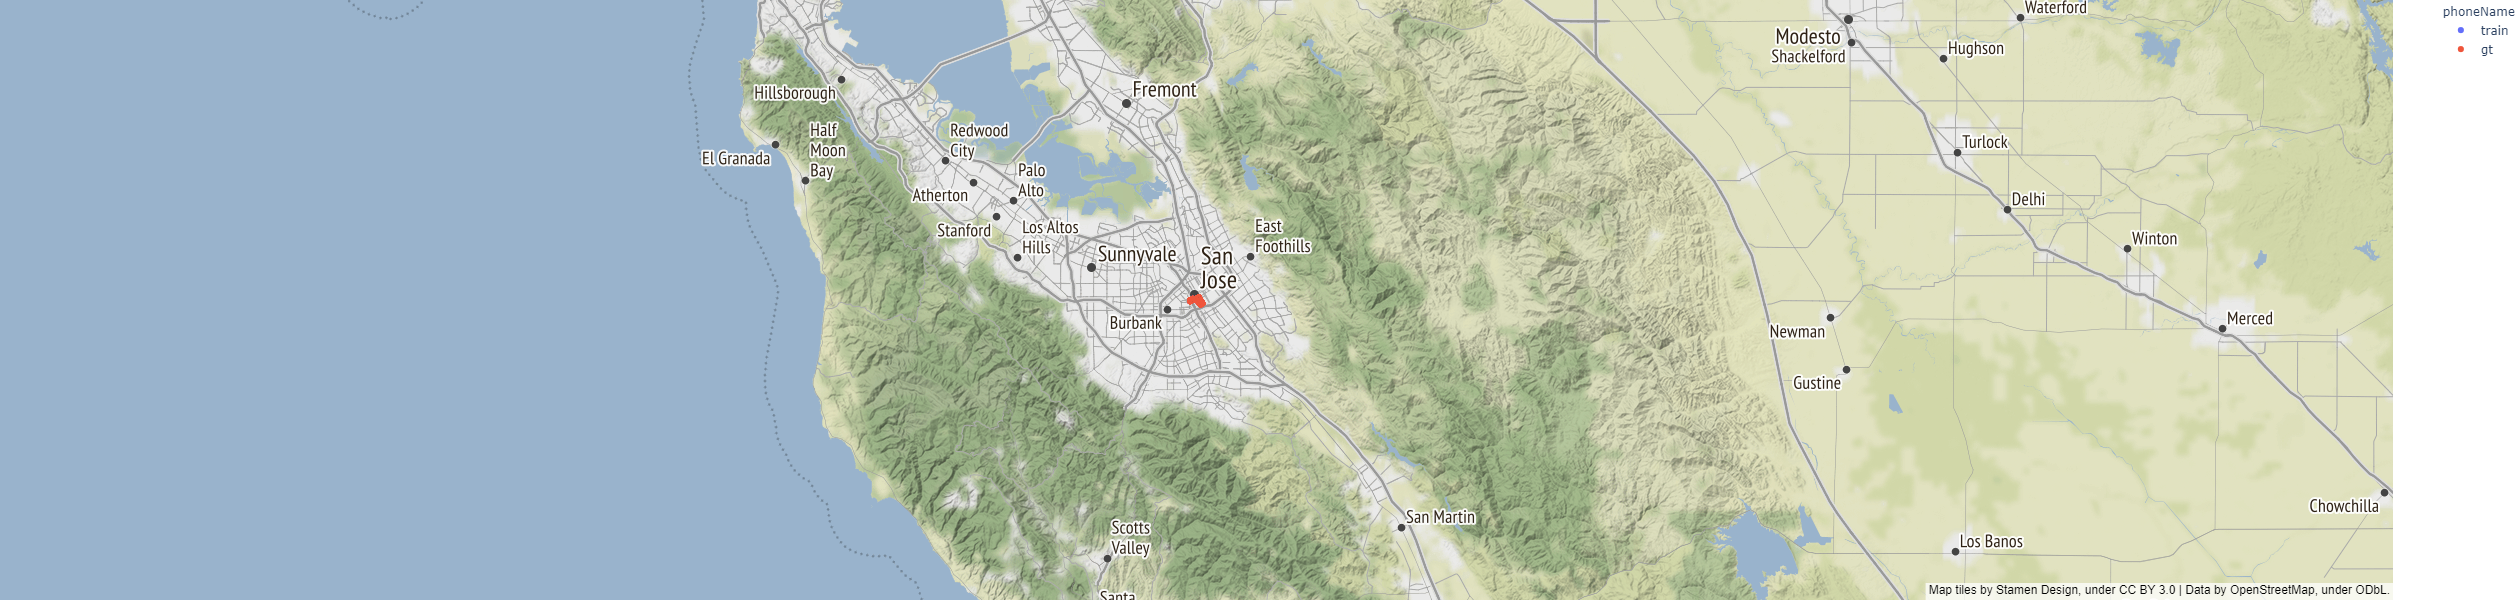

In [58]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# speed0の処理

In [59]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [60]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train = sp0_process(train, train_sp0_pred)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0.csv', index=False)

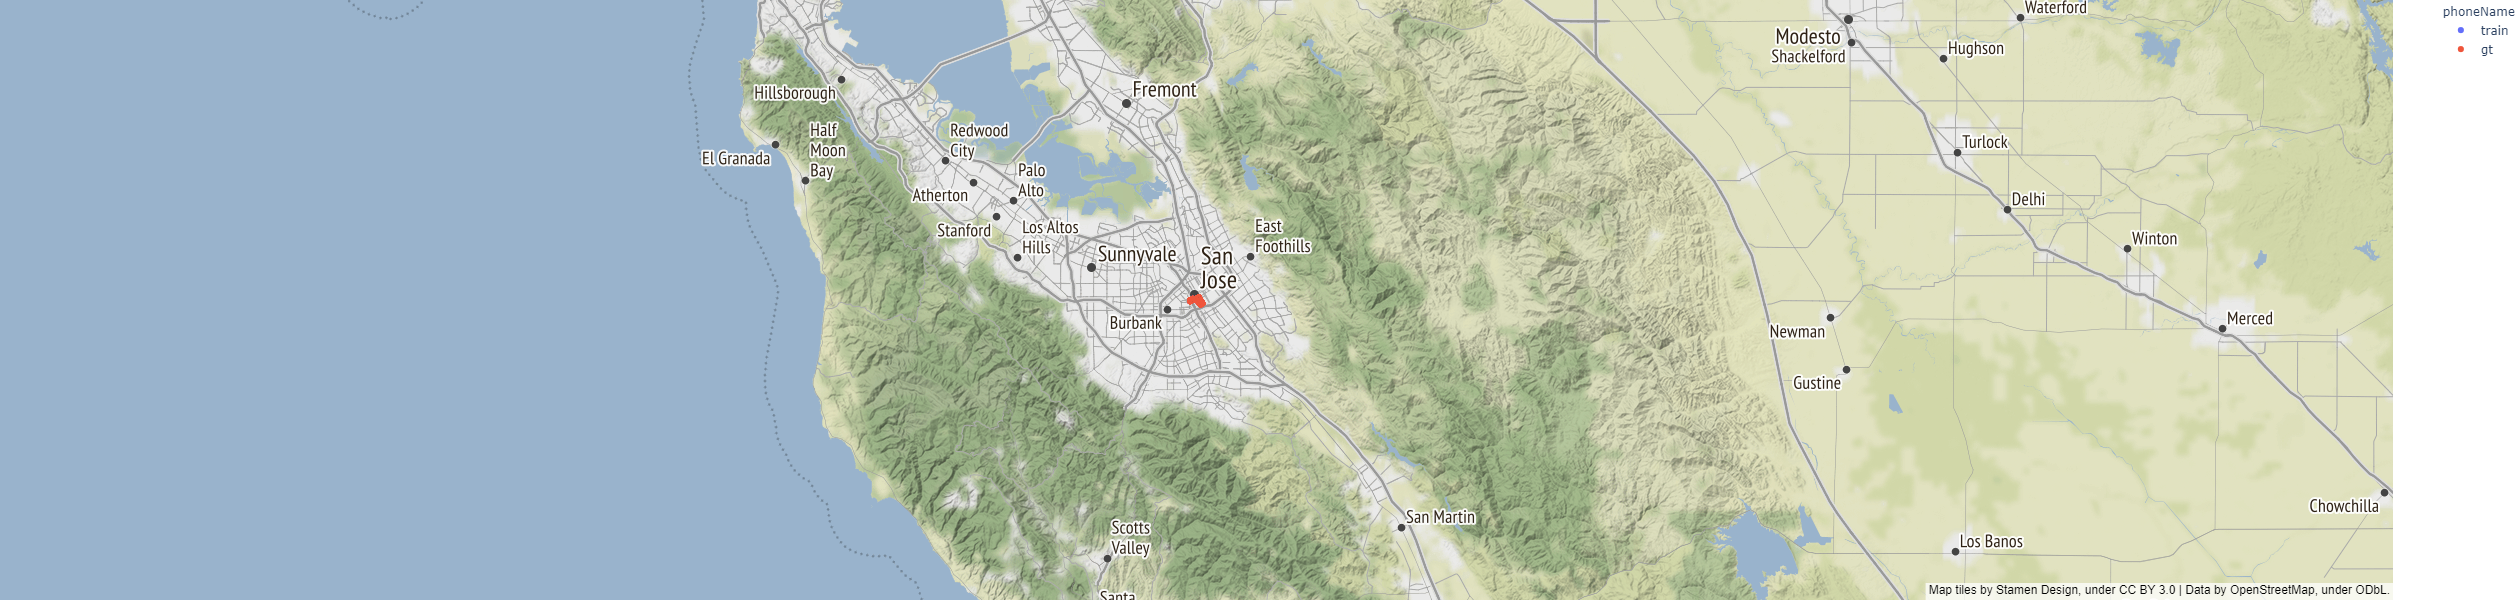

In [61]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

In [62]:
res = train_result(train)
print(res.score)
display(res.err)

10.201810737157043


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.007039     17.677790     11.342414
2021-04-22-US-SJC-1_SamsungS20Ultra      4.594299     17.323415     10.958857
2021-04-28-US-SJC-1_Pixel4               2.871606     16.492917      9.682261
2021-04-28-US-SJC-1_SamsungS20Ultra      3.415047     16.415170      9.915108
2021-04-29-US-SJC-2_Pixel4               2.747145     16.987891      9.867518
2021-04-29-US-SJC-2_SamsungS20Ultra      3.109693     15.779719      9.444706

# phones_mean

In [63]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [64]:
train_lerp = make_lerp_data(train)
train = calc_mean_pred(train, train_lerp)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm.csv', index=False)

In [65]:
res = train_result(train)
print(res.score)
display(res.err)

10.100874178871377


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.974365     17.391022     11.182694
2021-04-22-US-SJC-1_SamsungS20Ultra      4.650334     17.110353     10.880343
2021-04-28-US-SJC-1_Pixel4               2.936624     16.318796      9.627710
2021-04-28-US-SJC-1_SamsungS20Ultra      3.131239     16.585398      9.858319
2021-04-29-US-SJC-2_Pixel4               2.788385     16.228999      9.508692
2021-04-29-US-SJC-2_SamsungS20Ultra      2.921363     16.173613      9.547488

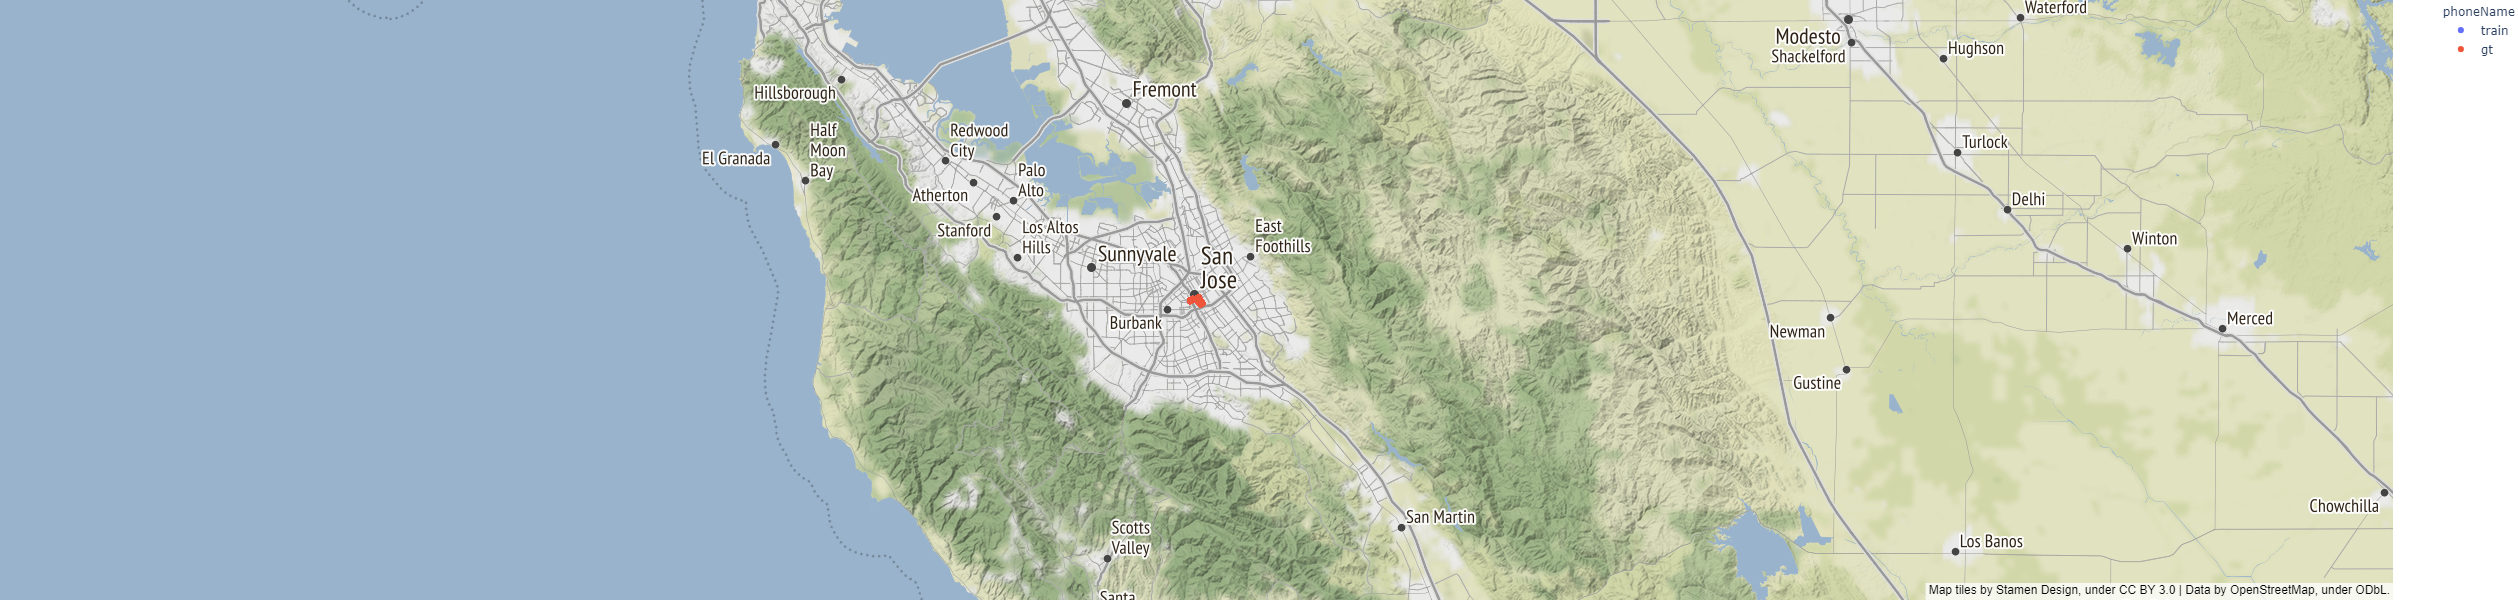

In [68]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# position_shift

In [69]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [70]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [71]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-06-26 17:41:25,322] A new study created in memory with name: no-name-fe0036be-5c33-4a1c-a9bd-7aab225e3a08
[I 2021-06-26 17:41:25,850] Trial 0 finished with value: 10.136260248085286 and parameters: {'a': -0.15566662312670654}. Best is trial 0 with value: 10.136260248085286.
[I 2021-06-26 17:41:26,268] Trial 1 finished with value: 10.006199652520467 and parameters: {'a': 0.48373171717355934}. Best is trial 1 with value: 10.006199652520467.
[I 2021-06-26 17:41:26,689] Trial 2 finished with value: 10.216325933643791 and parameters: {'a': -0.46406629061746707}. Best is trial 1 with value: 10.006199652520467.
[I 2021-06-26 17:41:27,107] Trial 3 finished with value: 10.358944556336597 and parameters: {'a': -0.9364563282428489}. Best is trial 1 with value: 10.006199652520467.
[I 2021-06-26 17:41:27,557] Trial 4 finished with value: 10.36072660635882 and parameters: {'a': -0.9416869741375349}. Best is trial 1 with value: 10.006199652520467.
[I 2021-06-26 17:41:28,106] Trial 5 finished 

0.9957273842097332


In [72]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

In [73]:
res = train_result(train)
print(res.score)
display(res.err)

9.928268794995113


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.411008     17.001859     10.706434
2021-04-22-US-SJC-1_SamsungS20Ultra      4.066260     17.110277     10.588268
2021-04-28-US-SJC-1_Pixel4               2.799900     16.318796      9.559348
2021-04-28-US-SJC-1_SamsungS20Ultra      3.015950     16.585398      9.800674
2021-04-29-US-SJC-2_Pixel4               2.681777     16.228999      9.455388
2021-04-29-US-SJC-2_SamsungS20Ultra      2.745389     16.173613      9.459501